In [1]:
import pandas as pd

import warnings
warnings.filterwarnings("ignore")

df_ais = pd.read_csv('ais_gameboard.csv')
df_centers = pd.read_csv('centers72.csv')
df_tiles = pd.read_csv('72x72map.csv')

In [2]:
#Isolate Lon/Lats
df = pd.DataFrame(columns = ['Lon', 'Lat'])
c = df_centers['geometry']
for i in range(len(c)):
    c[i] = c[i].strip("POINT (")
    c[i] = c[i].strip(")")   
df[['Lon', 'Lat']] = c.str.split(' ', expand=True)

#Lon/Lat to grid coordinates 
coords = []
for i in range(72):
    for j in range(72):
        coor = (j, i)
        coords.append(coor)
df['grid_coords'] = coords
df.to_csv('df_centers_clean.csv')

In [3]:
from tqdm import tqdm

#1-D index locations of AIS vessels - SLOW 
df_ais['grid_index'] = pd.Series()
for i in tqdm(range(len(df_ais))):
    diffs = []
    for j in range(len(df)):
        diff_sq = (df_ais['Longitude'][i] - df['Lon'].astype(float)[j])**2 + (df_ais['Latitude'][i] - df['Lat'].astype(float)[j])**2
        diff = diff_sq**(.5)
        diffs.append(diff)
    min_diff = min(diffs)
    df_ais['grid_index'][i] = diffs.index(min_diff)
df_ais.to_csv('df_ais_index.csv')

  0%|          | 1/228 [00:09<34:03,  9.00s/it]


KeyboardInterrupt: 

In [4]:
#1-D to 2-D
import numpy as np
tiles = df_tiles['Land'].to_numpy()
tiles = tiles-1
tiles = tiles.reshape(72,72)

#tiles = np.rot90(tiles, k=1)
#Counter clockwise rotation: A(x,y) becomes A'(-y,x)
#tiles = tiles.reshape(5184)

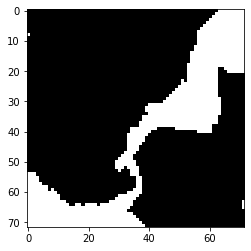

In [5]:
#Visualize grid
from matplotlib import pyplot as plt
plt.imshow(tiles, interpolation='nearest', cmap='bone')
plt.show()

In [6]:
#Origin grid indexes to coordinates
land, water = 1, 0  
df_ais = pd.read_csv('df_ais_index.csv')
df_ais['x'] = pd.Series()
df_ais['y'] = pd.Series()
for i, val in enumerate(df_ais['grid_index']):
    x = round(val % tiles.shape[0])   
    y = round(val / tiles.shape[0]) 
    if x == 72:
        x = 71
    if y == 72:
        y = 71
    
    #Translate off of land if AIS signal is on or too close
    if tiles[y][x] != land:
        df_ais['x'][i] = x
        df_ais['y'][i] = y
        continue
    elif y < 71 and tiles[y+1][x] != land:
        df_ais['x'][i] = x
        df_ais['y'][i] = y+1
        continue
    elif y > 1 and tiles[y-1][x] != land:
        df_ais['x'][i] = x
        df_ais['y'][i] = y-1
        continue
    elif x < 71 and tiles[y][x+1] != land:
        df_ais['x'][i] = x+1
        df_ais['y'][i] = y
        continue
    elif x > 1 and tiles[y][x-1] != land:
        df_ais['x'][i] = x-1
        df_ais['y'][i] = y
        continue
        
    elif x > 2 and tiles[y][x-2] != land:
        df_ais['x'][i] = x-2
        df_ais['y'][i] = y
        continue
    elif y > 2 and tiles[y-2][x] != land:
        df_ais['x'][i] = x
        df_ais['y'][i] = y-2
        continue
    elif x < 70 and tiles[y][x+2] != land:
        df_ais['x'][i] = x+2
        df_ais['y'][i] = y
        continue
    elif y < 70 and tiles[y+2][x] != land:
        df_ais['x'][i] = x
        df_ais['y'][i] = y+2
        continue  
        
    elif x > 3 and tiles[y][x-3] != land:
        df_ais['x'][i] = x-3
        df_ais['y'][i] = y
        continue
    elif y > 3 and tiles[y-3][x] != land:
        df_ais['x'][i] = x
        df_ais['y'][i] = y-3
        continue
    elif x < 69 and tiles[y][x+3] != land:
        df_ais['x'][i] = x+3
        df_ais['y'][i] = y
        continue
    elif y < 69 and tiles[y+3][x] != land:
        df_ais['x'][i] = x
        df_ais['y'][i] = y+3
        continue  
        
df_ais.to_csv('df_ais_index_coord.csv')

In [12]:
import random as rand

#Meander behavior
def meander(grid, start):
    land, water = 1, 0  
    direction = rand.choice(['north', 'south', 'east', 'west', 'stay'])
    if direction == 'north':
        d = (1, 0)
    elif direction == 'south':
        d = (-1, 0)
    elif direction == 'east':
        d = (0, 1)
    elif direction == 'west':
        d = (0, -1)
    else:
        d = (0, 0)
        
    y = start[1]+d[1]
    x = start[0]+d[0]
    if 0 <= x < 72 and 0 <= y < 72 and grid[y][x] != land:
        return (x, y)
    else:
        return(start[0], start[1])
        
#Stationary behavior       
def stationary(start):
    return start

In [8]:
import collections

#Moving along shortest path to random predetermined destination behavior (breadth-first search)
def bfs(grid, start):
    land, water = 1, 0               
    width, height = grid.shape[0], grid.shape[0]
    dest_x = rand.randint(0, 72)
    dest_y = rand.randint(0, 72)
    dest = (dest_x, dest_y)
    queue = collections.deque([[start]])
    seen = set([start])
    while queue:
        path = queue.popleft()
        x, y = path[-1]
        if (x, y) == dest:
            return path
        for x2, y2 in ((x+1,y), (x-1,y), (x,y+1), (x,y-1)):
            if 0 <= x2 < width and 0 <= y2 < height and grid[y2][x2] != land and (x2, y2) not in seen:
                queue.append(path + [(x2, y2)])
                seen.add((x2, y2))

In [13]:
#Return random path of vessel
def get_path(origin, grid, time_steps):
    
    behavior = np.random.choice(['stationary', 'meander', 'bfs'], p=[.1, .2, .7])
    
    if behavior == 'stationary':
        path = stationary([origin]*time_steps)
        #print('stationary')
        
    if behavior ==  'meander':
        path = []
        for i in range(time_steps):
            path.append(meander(grid, origin))
            origin = meander(grid, origin)
        #print('meander')
        
    if behavior == 'bfs':
        #3 bfs trips/paths make up cumulative returned path
        path1 = None
        while path1 == None or len(path1) <= 18:
            path1 = bfs(grid=grid, start=origin)
            if path1 != None and len(path1) >= 18:
                break

        path2 = None
        while path2 == None or len(path2) <= 18:
            path2 = bfs(grid=grid, start=path1[-1])
            if path2 != None and len(path2) >= 18:
                break
        path2 = path1 + path2

        path3 = None
        while path3 == None or len(path3) <= 18:
            path3 = bfs(grid=grid, start=path2[-1])
            if path3 != None and len(path3) >= 18:
                break
        path3 = path2 + path3
        
        path4 = None
        while path4 == None or len(path4) <= 18:
            path4 = bfs(grid=grid, start=path3[-1])
            if path4 != None and len(path4) >= 18:
                break
        path4 = path3 + path4

        rep = 4 #Number of time steps spent in one grid square    
        path = [entry for entry in path4 for _ in range(rep)]
        path = path[:time_steps]
        #print('bfs')
        
    return path

In [14]:
import numpy as np
import pandas as pd
from tqdm import tqdm

df_key = pd.read_csv('df_centers_clean.csv')
df_paths = pd.DataFrame(columns = ['idx', 'Longitude', 'Latitude'], index=range(223*288))
df_ais = pd.read_csv('df_ais_index_coord.csv')

#for i in range(288):
#     df_paths[[f'Lon_{i}', f'Lat_{i}']] = None, None
    
tiles = df_tiles['Land'].to_numpy()
tiles = tiles-1
tiles = tiles.reshape(72,72)

for i in tqdm(range(223)):
    x = int(df_ais['x'][i])
    y = int(df_ais['y'][i])
    
    path = get_path(origin=(x, y), grid=tiles, time_steps=288)
    #print(path)
    for p, coord in enumerate(path):
        idx = df_key.index[df_key['grid_coords'] == str(coord)]
        lon = df_key['Lon'][idx].values
        lat = df_key['Lat'][idx].values
       
        df_paths['idx'][int(p*223+i)] = p
        df_paths['Longitude'][int(p*223+i)] = lon[0]
        df_paths['Latitude'][int(p*223+i)] = lat[0]

#         df_paths[f"Lon_{p}"][i] = lon[0]
#         df_paths[f"Lat_{p}"][i] = lat[0]
df_paths.to_csv('ais_paths.csv', index=False)

100%|██████████| 223/223 [04:02<00:00,  1.09s/it]
